In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import mne
mne.set_log_level(False)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns
from os import listdir

sourceloc = "../sempred/" # location of saved epochs
out_template = sourceloc + "/{0}-{1}-{2}.fif"

In [2]:
bad_subjs = {"ANA11","SKK20","GMA05", "PBT16","HHA01","BSN17","AHA31", "KHA01", "KKA17",
            "RAC22", # broken ground
            "VLA21", # not a native speaker of German
            }
subjsC = [file.split("-")[0] for file in listdir(sourceloc) 
                            if file.split("-")[0] not in bad_subjs and "aw" in file]
len(subjsC)

35

In [3]:
bad_subjsA = {"AJA28", "EKI28", "PAA15", "RRK21", "SPN30", "UDE20","HFE14","SON11","CMA02"}
subjsA = [file.split("-")[0] for file in listdir(sourceloc) 
                                              if "anim" in file and file.split("-")[0] not in bad_subjsA]
len(subjsA)

35

In [4]:
def get_epoch(name, exp):
    '''load epochs'''
    epoch = mne.read_epochs(out_template.format(name,exp, "epo")).crop(tmax=1.)
    return (epoch if exp=="anim" else epoch.drop_channels(["SO1","SO2"]))

In [5]:
def get_erp_data(exp, on_targets=False, on_ica=False):
    '''
    Creates a dict of ERP data.
    
    names: dict of names by experiment
    exp: (ex: 'anim', 'cct', 'aw', 'vw')
    on_targets: only if exp='anim' or 'cct', time-locks to target word onset as opposed to delay   
    
    returns a dict with subcategories of erps (averaged ERPs per condition per subject), gr_avg (grand average ERP), 
    diff_erp (averaged difference ERP per subject - Concrete minus Abstract or Inanimate minus Animate conditions),
    diff_gr_avg (grand average difference ERP across subjects)
    '''
    # create a list of epoched data
    if exp=="anim":
        epoch_l=[get_epoch(name, exp)
                 for name in subjsA] 
    else:
        epoch_l=[get_epoch(name, exp)
                 for name in subjsC] 
    # identify what conditions based on experiment
    ev_id = epoch_l[0].event_id
    conds = [k for k in epoch_l[0].event_id.keys()]
    evs = [ev_id[ev] for ev in ev_id]    
    # create a dict of calculated averaged ERPs per conditions per subject
    erps_ = dict() 
    for ii,  cond in enumerate(ev_id):
        erps_[cond]= [erp[cond].average() for erp in epoch_l]

    # create a dict of erps
    erp=dict()
    erp["erps"] = erps_ # dict of averaged ERPs per condition per subject
    erp["gr_avg"] = mne.grand_average([ep.average().detrend() for ep in epoch_l]).apply_baseline() # grand average ERP
    erp["diff_erp"]=[mne.combine_evoked([-ep[conds[0]].average(), ep[conds[-1]].average()], # per subject difference ERP
                                 weights="equal") for ep in epoch_l] # difference erps for subjects
    erp["diff_gr_avg"] = mne.grand_average(erp["diff_erp"]).apply_baseline() # Grand Average difference ERP
    
    return erp 

In [6]:
erps = dict() # create a dictionary of dictionaries for ERP data
for exp in ("abst_cct", "vw", "aw", "anim"):
    erps[exp] = get_erp_data(exp=exp)

In [7]:
# STATS
from mne.stats import spatio_temporal_cluster_1samp_test as stct
from mne.channels.layout import find_layout
def get_connectivities(exp):

    # make connectivity and plot
    epoch = get_epoch((subjsA[0] if exp=="anim" else subjsC[0]), exp) # load an example epoch

    montage = mne.channels.montage.read_montage("/data/hippocampus/conincon/sempred/m.elp") # location of montage file
    # delete EOG
    montage.selection = montage.selection[0:-2:]
    montage.ch_names = montage.ch_names[0:-2:]
    montage.pos = montage.pos[0:-2:]
    info = mne.create_info(epoch.ch_names, 100, "eeg", montage)

    pos_xy = find_layout(info).pos[:, :2]
    n_chans = len(pos_xy)
    pos_x, pos_y = pos_xy.T

    #connectivities = mne.spatial_tris_connectivity(tri.simplices).toarray()
    conn, ch_names = mne.channels.find_ch_connectivity(epoch.info, 'eeg')
    connectivities = conn.toarray()

    # get rid of frontal connectivities that do not exist.
    #print('Manually deleting frontal connections')
    badConns = [['AF7','AF8'], ['AF7','AFz'], ['AF8','AFz']]
    #print(badConns)
    
    # connectivities is 60*60
    inds = []
    for l in badConns:
        ind1 = np.asarray([1 if ch_nm == l[0] else 0 for ch_nm in montage.ch_names])
        ind1 = np.where(ind1)[0]
    #     print(ind1)
        ind2 = np.asarray([1 if ch_nm == l[1] else 0 for ch_nm in montage.ch_names])
        ind2 = np.where(ind2)[0]
    #     print(ind2)
        inds.append((ind1,ind2))

    for idxs in inds:
        connectivities[idxs[0],idxs[1]] = 0
        connectivities[idxs[1],idxs[0]] = 0

    from scipy.sparse.csc import csc_matrix

    return csc_matrix(connectivities)
     

In [8]:
def make_clustest(mmn_d, connectivity, alpha=.05): # spatio temporal cluster 1 sample ttest
    '''spatiotemporal clustering test'''
    T_obs, clusters, cluster_pv, H0 = stct(mmn_d,  # mm_d is the data array, check the function for dimensions
                                          connectivity=connectivity,
                                          n_jobs=-1, out_type='mask',n_permutations = 1024)
    inds = (np.mean([c for c, cp in zip(clusters, cluster_pv)
                    if cp < alpha], axis=0) > 0) # alpha is the threshold for p-values
    return inds, T_obs, clusters, cluster_pv, H0 # returns array of boolean values corresponding to whether threshold was passed

    
def test_against0(gavg,evokeds, exp, plot=False):
    '''the stats and masking for plotting, testing difference from the grand average
    gavg: grand average
    evokeds: the average difference per subject
    '''
    connectivities = get_connectivities(exp)
    erp = copy.deepcopy(gavg)  # an Evoked object with the grand average we're testing against 0
    # extract data for spatio temporal clustering.
    # (observations x time x space) -> len(names) * samps * electrodes
    evs = copy.deepcopy(evokeds)
    
    ## only run statistics on 0-1000 ms ##
    for ev in evs:
        ev.crop(0,1)
    erp.crop(0,1)

    statDat = np.empty((len(evs),evs[0].data.shape[1],evs[0].data.shape[0]))
    statDat[:] = np.nan
    for n,ev in enumerate(evs):
        dat = ev.data;
        dat = dat[:,:,np.newaxis]
        dat = dat.transpose((2,1,0))
        statDat[n,:,:] = dat

    inds, T_obs, clusters, cluster_pv, H0 = make_clustest(mmn_d = statDat, connectivity=connectivities, alpha=.05) # cluster based test

    if plot==True:
        plot_masked_image(erp);
        plot_masked_image(erp, inds=inds);
    return erp,inds

In [9]:
def check_1020_hemisphere(name):
    """Decide if a 10-20 channel is on the left,
    right or midline, based on its name"""
    n = name[-1].lower()
    if n in {"z", '1', '2'}: # example: C1, Cz, and FC2 would be midline
        return 'midline'
    else:
        return "left" if bool(int(n) % 2) else "right" # if not divisible by 2, left,  else right hemisphere


def do_one_hemi(evoked,exp, pos_y, p_vals, ax, position, indices, vmin, vmax, tmin, tmax, image_alpha,
                alpha, alphas, do_contours, label_contours, unit, jj=0):
    
    from matplotlib.lines import Line2D
    s = "{}\n\n{}\n".format(("Channels\n< back <       > front >"
                           if position == "midline" else ""), position)
    ax.set_ylabel(s)
    picks = pos_y[indices].argsort() # sort channels front to back
    data = evoked.data[indices][picks] * 1000000.0 # convert to uV
    
    # dict for naming figure
    titles = {"anim": "Delayed Words","cct": "Delayed Words",
              "aw": "Auditory Word Lists","vw": "Visual Word Lists"} 
    
    # set figure title above the upper plot only
    if jj==0:
        ax.set_title("Masked Channel-Wise Difference Activity for {} \n ({})".format(titles[exp],("Inanimate-Animate" 
                                                                                                  if exp=='anim'
                                                                                                  else "Concrete-Abstract")))
    
    # plot data
    ax.vlines(0, 0, len(picks), linestyle=":", color="grey") # reference onset of event (t=0)
    im_args = dict(extent=(tmin, tmax, 0, len(data)), aspect="auto", cmap="RdBu_r",
                   interpolation='gaussian', origin="lower", vmin=vmin, vmax=vmax)
    im = ax.imshow(data,**im_args)
    ax.set_yticks(np.arange(len(picks)) + .5)
    ax.set_yticklabels(np.array(evoked.ch_names)[indices][picks], fontdict={'fontsize':11})    
    ax.set_xlabel(("Time (ms)" if jj==2 else ""))
    
    # plot contours for significance masking if significant clusters found
    ls = list()
    a = type(np.False_)
    if not isinstance(inds, a):
        p_vals_ = p_vals[indices][picks]
        if do_contours:
            for ii, alpha in enumerate(alphas):
                cs = ax.contour(p_vals_, antialiase=True, levels=[alpha], linestyle="--",
                                origin="lower", cmap='Greys_r', alpha=(1 - (ii / len(alphas))) * .666,
                                extent=(tmin, tmax, -.5, len(data)+.5) )
                ls.append(Line2D((0, 0), (0, 0), color="k", label='p < ' + str(alpha),
                                 alpha=(1 - (ii / len(alphas)))*.666))
                if label_contours:
                    ax.clabel(cs, fontsize=13, fmt={alpha:'p < ' + str(alpha)},
                              levels=[alpha], inline_spacing=-1, antialiased=True)    
    return ls, im


def plot_image_hemi(evoked, p_vals, exp, alpha=.05, alphas=[.05], do_contours=True, unit=1e6,
                    size=(8, 12), title='', colorbar="uV", label_contours=False, image_alpha=1.):
    "pvals=2D (channels, times), alpha: image mask, alphas=contours"
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from mne.channels.layout import _find_topomap_coords
    
    pos_xy = np.asarray(_find_topomap_coords(evoked.info, range(len(evoked.ch_names))))
    pos_x, pos_y = pos_xy.T
    hemi = np.asarray([check_1020_hemisphere(ch) for ch in evoked.ch_names])
    positions = sorted(list(set(hemi)))
    f, axes = plt.subplots(len(positions), 1, sharex=True)
    f.set_size_inches(size)
    tmin, *_, tmax = evoked.times*1000 # set time limits and convert to ms
    vmin,  vmax = -1.25 , 1.25 # set limits for figure (i.e. color bar extent)

    # plot 3 separate subplots of left, right, midline channels by enumerating over sections
    for jj, (ax, position) in enumerate(zip(axes, positions)):
        indices = [hemi == position]
        ls, im = do_one_hemi(evoked,exp, pos_y, p_vals, ax, position, indices, vmin, vmax, tmin, tmax,
                         image_alpha, alpha, alphas, do_contours, label_contours, unit, jj=jj)
    
    # draw the  legend for masking and indicate its position
    ax.legend(ls, ['p < ' + str(alpha) for alpha in alphas],
          loc='upper right', bbox_to_anchor=(1.4,-0.2)) 
    
    # color bar specification of figure
    if colorbar:
        f.colorbar(im, ax=axes[:3].ravel().tolist(), fraction=.1, aspect=40, pad=.07,shrink=.8,
                   label=colorbar, orientation="vertical")
    f.suptitle(title, y=.925)
    return f

# Significance Testing for Abstract/Concrete Pauses
- no significant clusters identified

In [22]:
exp = "abst_cct"
erC,inds = test_against0(erps[exp]["gr_avg"], erps[exp]["diff_erp"], exp) 
new_indsC = np.full((261, 60), False, dtype=bool)
new_indsC[60:, :]=inds.copy()

Manually deleting frontal connections
[['AF7', 'AF8'], ['AF7', 'AFz'], ['AF8', 'AFz']]


/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


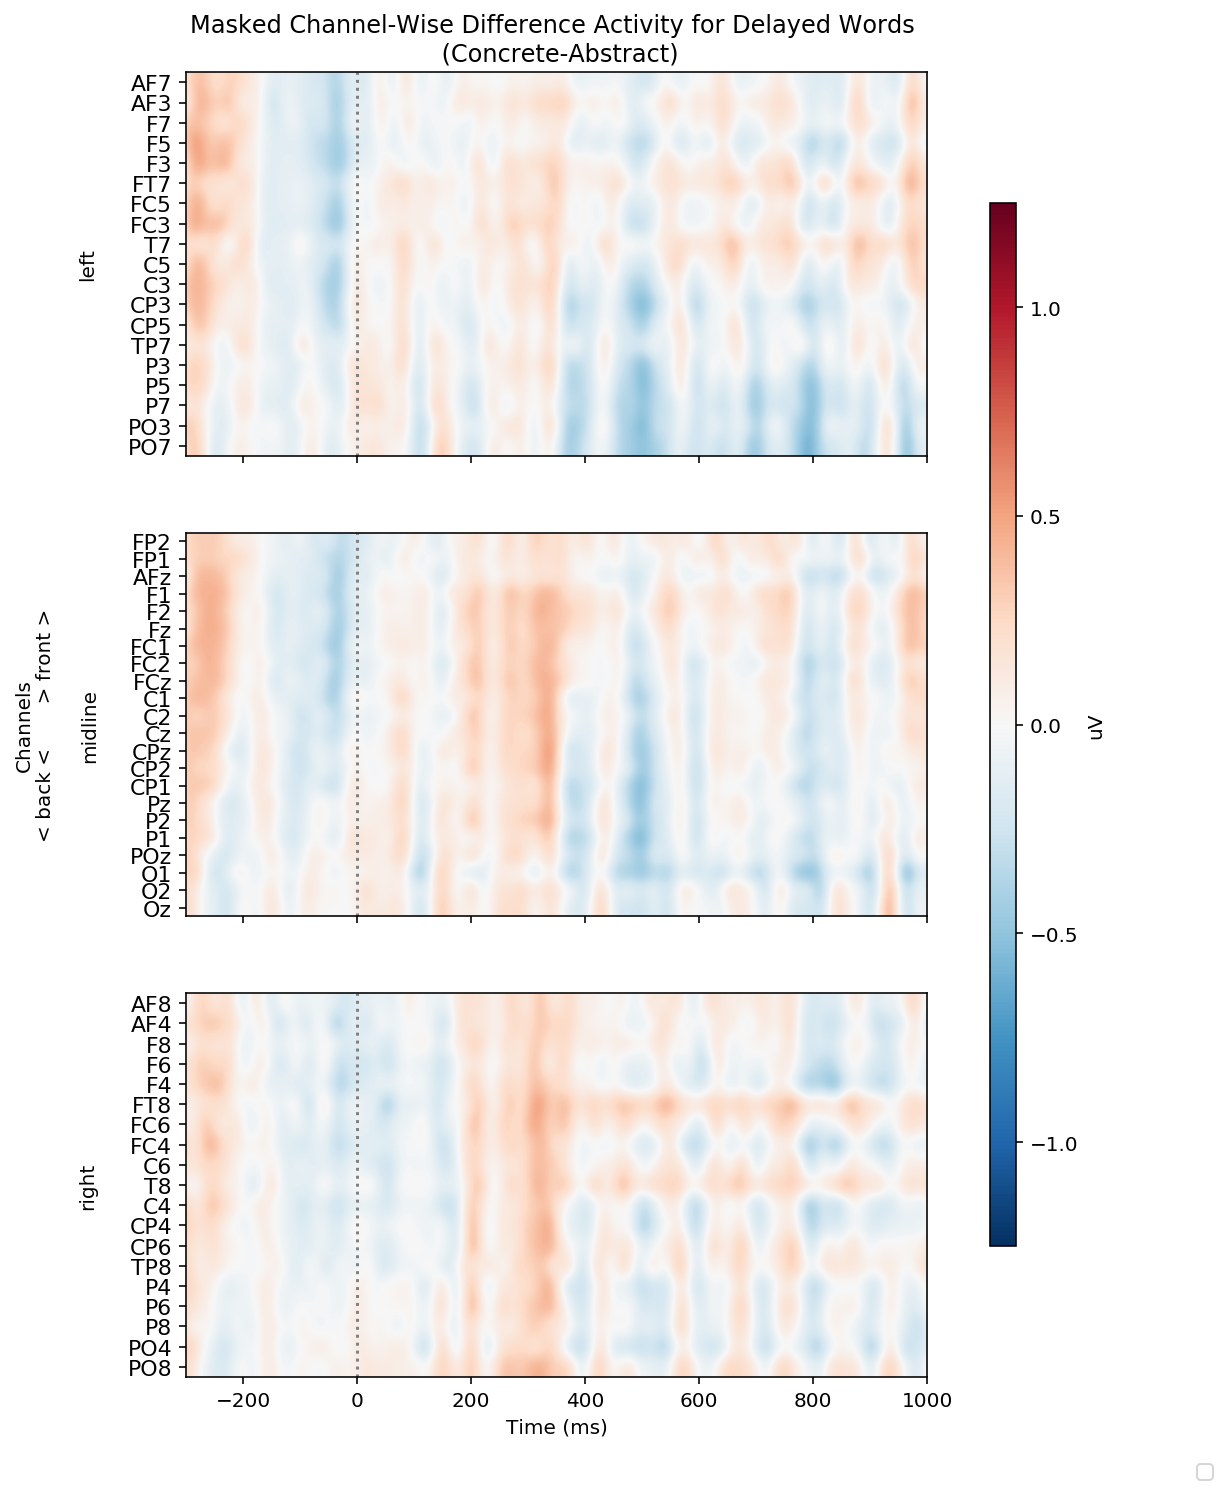

In [23]:
# plot channel-wise difference activity and mask for significance using contours (no significant clusters) 
# (concrete-abstract)
plot_image_hemi(erps['abst_cct']["diff_gr_avg"], p_vals=new_indsC.T, exp="cct");

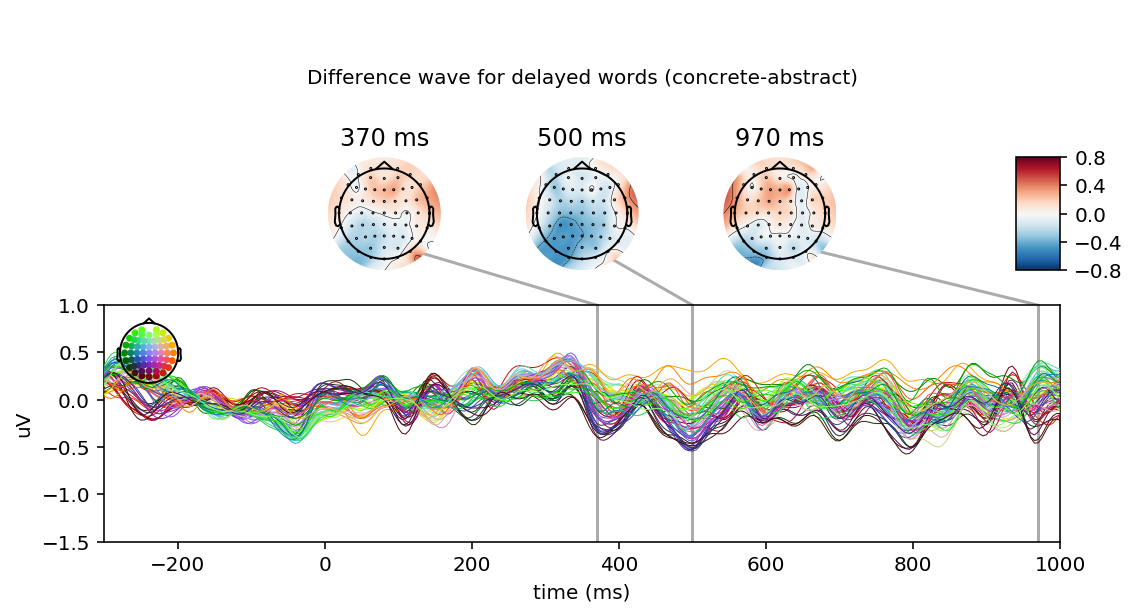

In [24]:
# plot difference plot (butterfly plot) indexing significant clusters in the topoplots (none found) (concrete-abstract)
# no significant time points so topomaps index 3 local 'difference' points of maxima in Global Field Power
topomap_args = dict(mask=(new_indsC.T if str(type(inds))=="<class 'numpy.ndarray'>" else None),
     mask_params={"markersize":6},average=.05, vmin=-.8, vmax=.8)

erps['abst_cct']["diff_gr_avg"].plot_joint(topomap_args=topomap_args,ts_args={"ylim":{"eeg":[-1.5, 1.0]}},
                                             title="Difference wave for delayed words (concrete-abstract)");

# Significance Testing Auditory Word Lists 
- significant clusters from 200-365 ms



In [25]:
exp = "aw"
er,inds = test_against0(erps[exp]["gr_avg"], erps[exp]["diff_erp"], exp) 
new_indsA = np.full((261, 60), False, dtype=bool)
new_indsA[60:, :]=inds.copy()

Manually deleting frontal connections
[['AF7', 'AF8'], ['AF7', 'AFz'], ['AF8', 'AFz']]


/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'antialiase', 'linestyle'
  s)


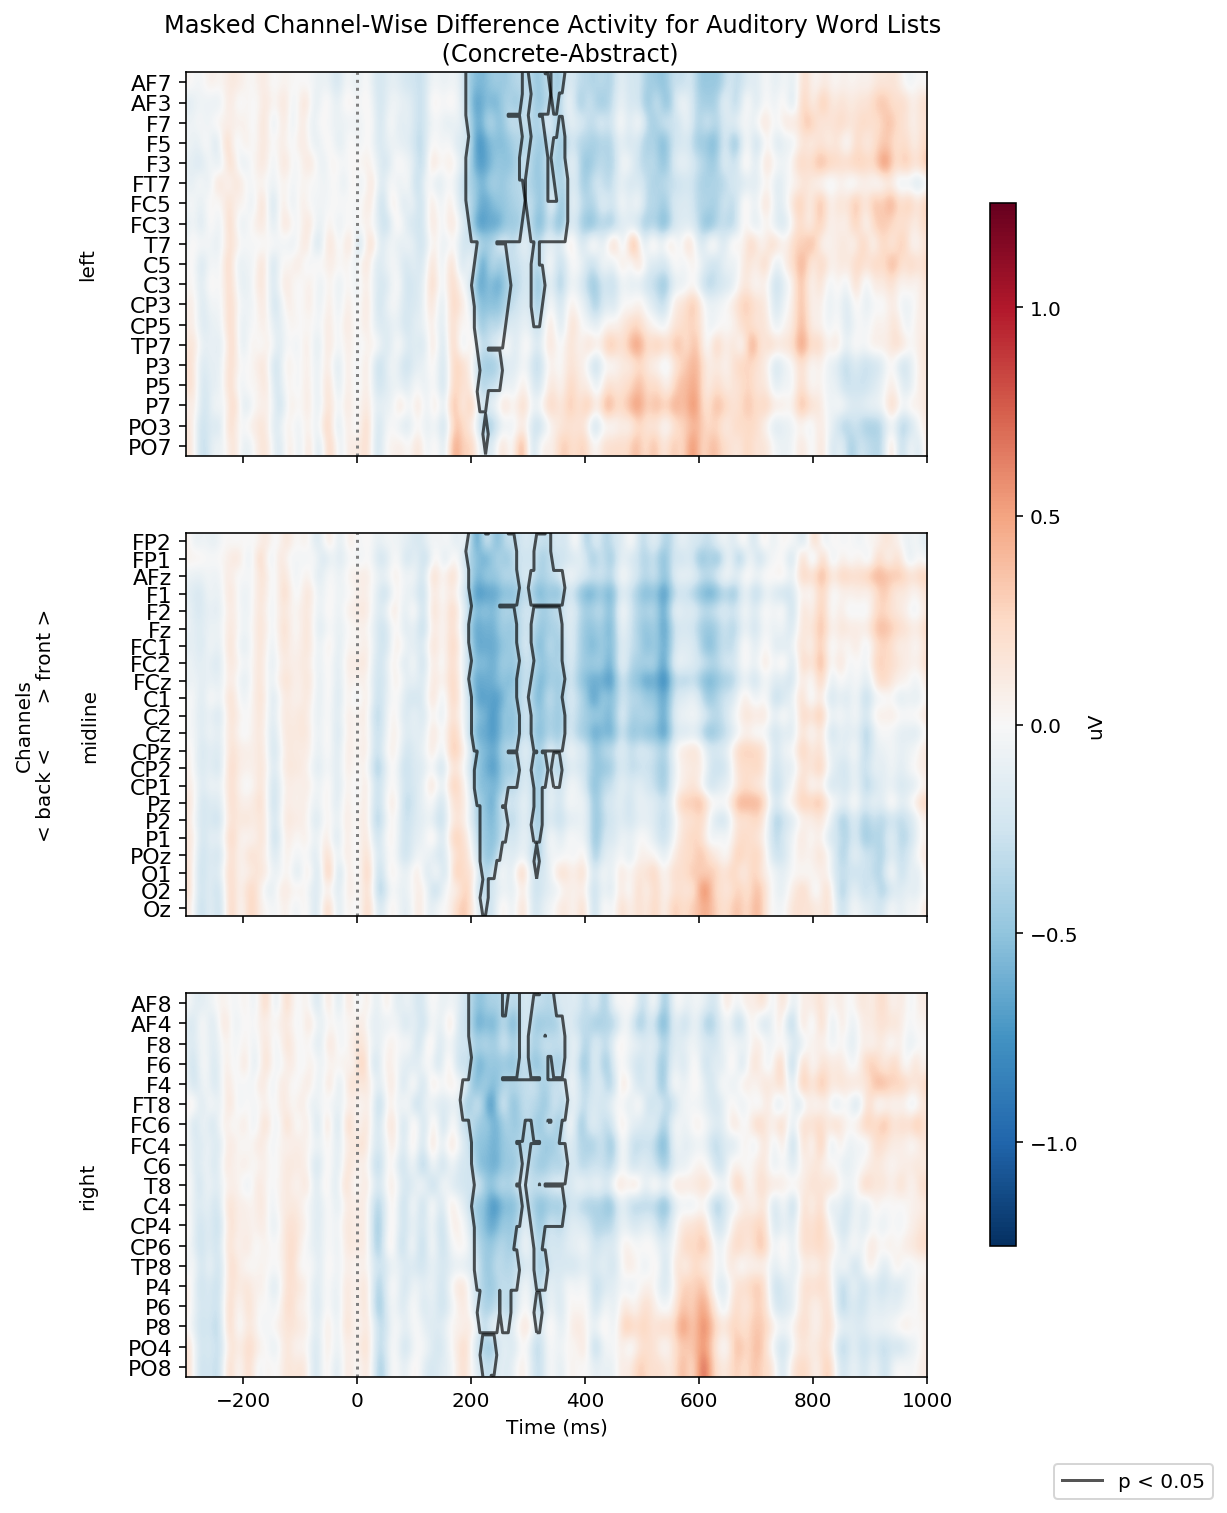

In [26]:
# plot channel-wise difference activity and mask for significance using contours (concrete-abstract)
plot_image_hemi(erps['aw']["diff_gr_avg"], p_vals=new_indsA.T, exp="aw");

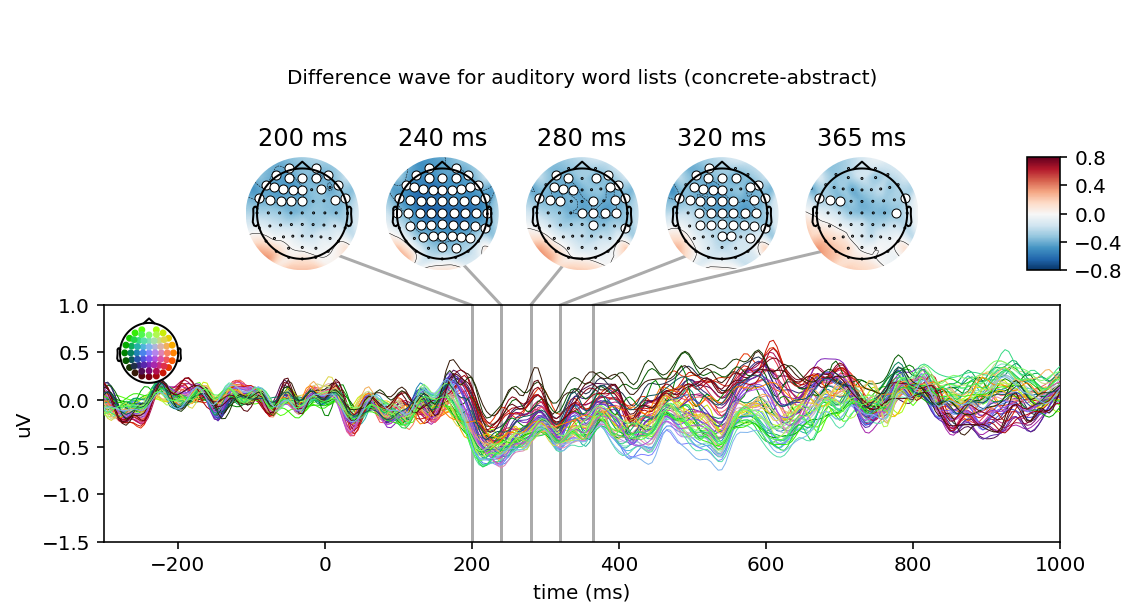

In [27]:
# plot difference plot (butterfly plot) indexing significant clusters in the topoplots(concrete-abstract)
topomap_args = dict(mask=new_indsA.T,  mask_params={"markersize":6,"markersize":9 }, average=.05, vmin=-.8, vmax=.8) 

erps['aw']["diff_gr_avg"].plot_joint(times=[.20, .24,  .28,  0.32, .365], topomap_args=topomap_args, 
                                     ts_args={"ylim":{"eeg":[-1.5, 1.0]}}, 
                                     title="Difference wave for auditory word lists (concrete-abstract)");

# Significance Testing Visual Word Lists
- significant clusters from 165 -630 ms

In [28]:
exp = "vw"
er,inds = test_against0(erps[exp]["gr_avg"], erps[exp]["diff_erp"], exp) 
new_indsV = np.full((261, 60), False, dtype=bool)
new_indsV[60:261, :]=inds.copy()

Manually deleting frontal connections
[['AF7', 'AF8'], ['AF7', 'AFz'], ['AF8', 'AFz']]


/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'antialiase', 'linestyle'
  s)


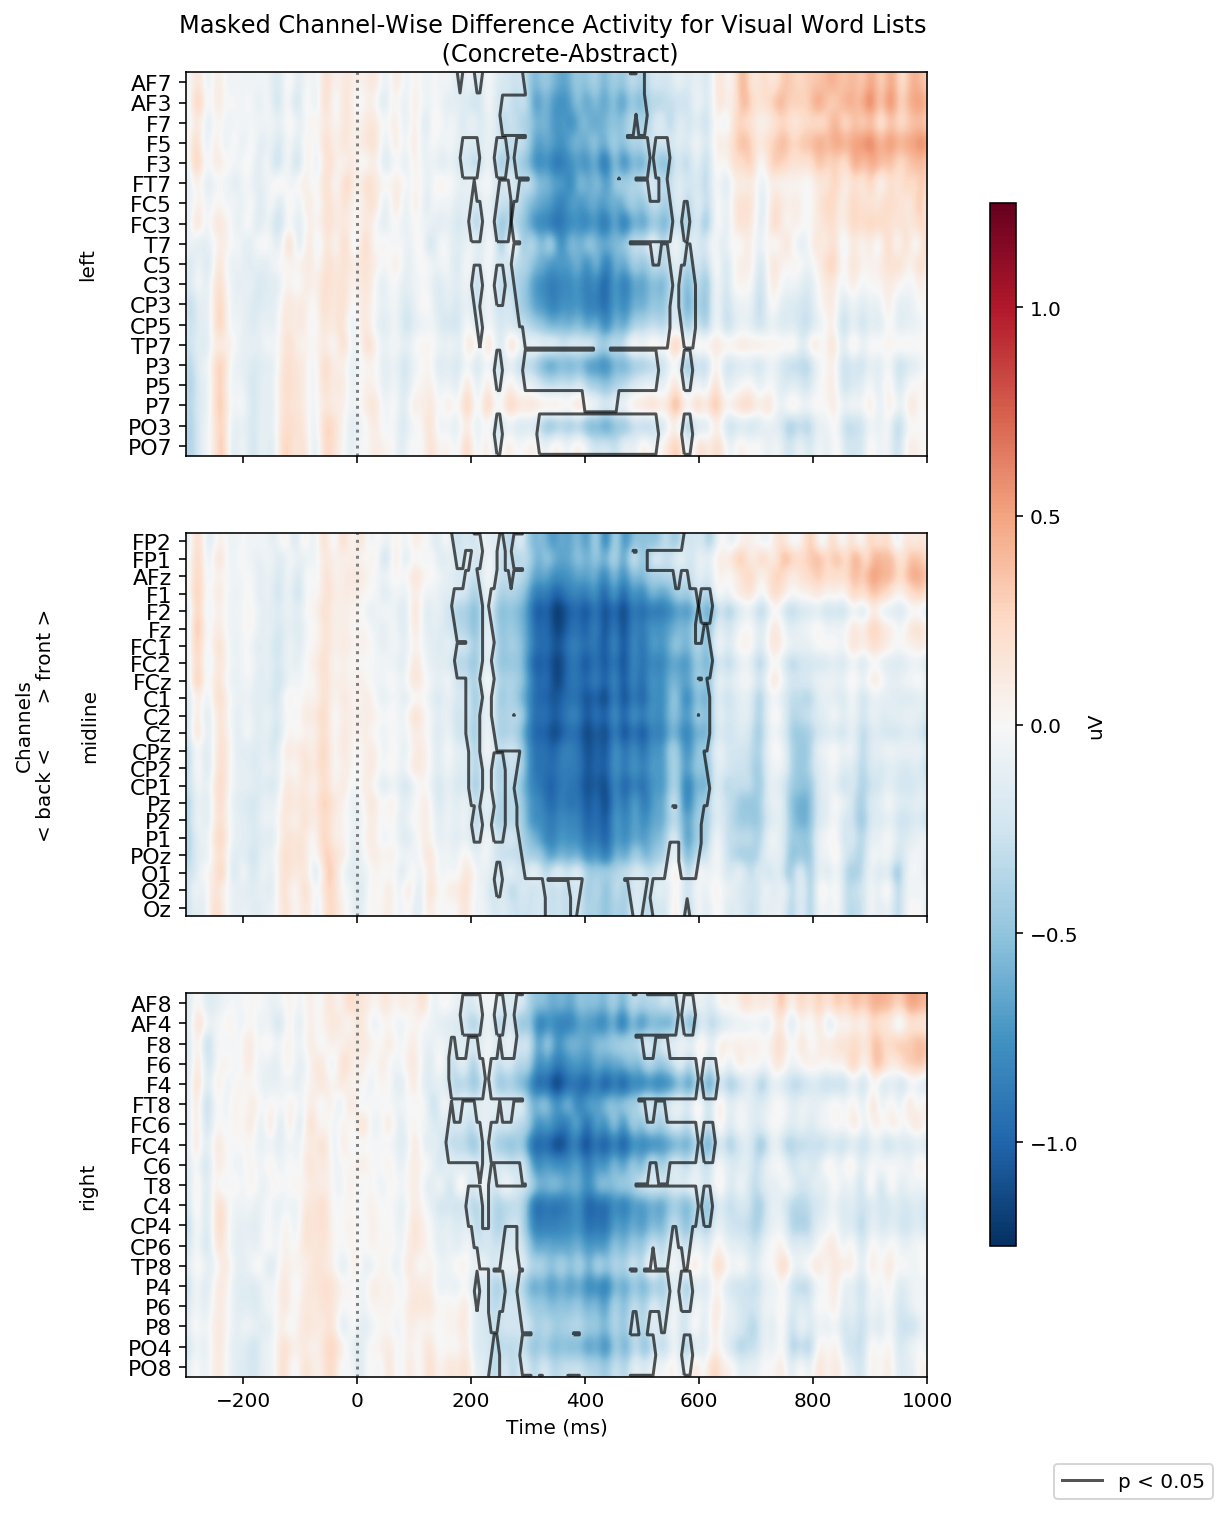

In [29]:
# plot channel-wise difference activity and mask for significance using contours (concrete-abstract)
plot_image_hemi(erps['vw']["diff_gr_avg"], p_vals=new_indsV.T, exp="vw");

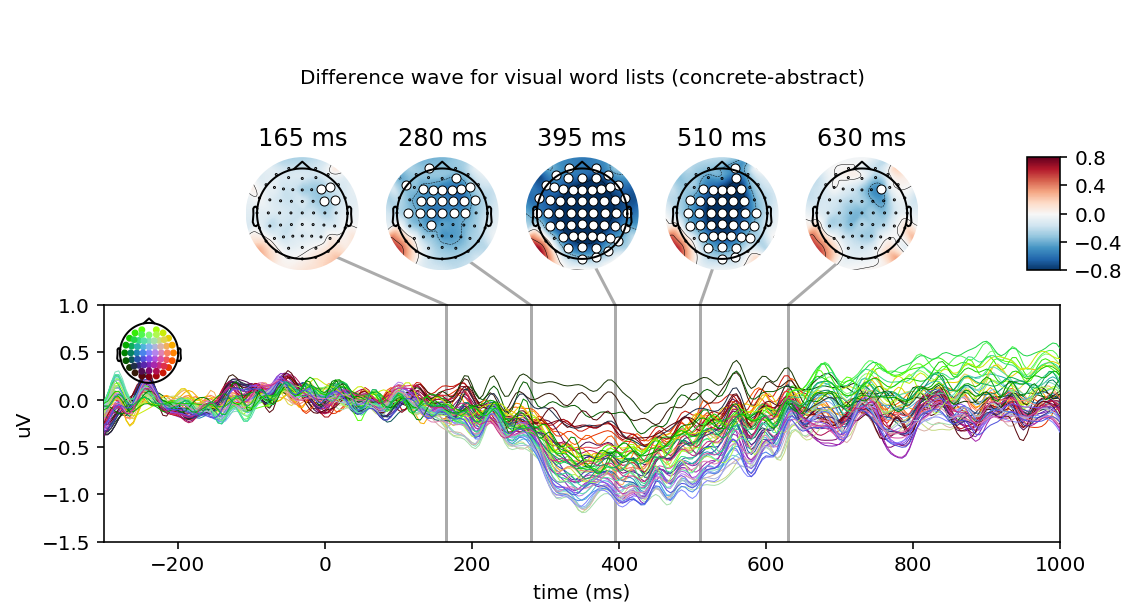

In [30]:
# plot difference plot (butterfly plot) indexing significant clusters in the topoplots(concrete-abstract)
topomap_args = dict(mask=(new_indsV.T if str(type(inds))=="<class 'numpy.ndarray'>" else None),
     mask_params={"markersize":6,"markersize":9},average=.05, vmin=-.8, vmax=.8) 

erps['vw']["diff_gr_avg"].plot_joint(times=[0.165, 0.28 , 0.395, 0.51, .630], topomap_args=topomap_args,
                                            ts_args={"ylim":{"eeg":[-1.5, 1.0]}},
                                       title="Difference wave for visual word lists (concrete-abstract)");

# Significance Testing for Animate/Inanimate Pauses
 - no significant pauses

In [31]:
# significance testing
exp = "anim"
er,inds = test_against0(erps[exp]["gr_avg"], erps[exp]["diff_erp"], exp) 
new_indsANIM = np.full((261, 58), False, dtype=bool)
new_indsANIM[60:, :]=inds.copy()

Manually deleting frontal connections
[['AF7', 'AF8'], ['AF7', 'AFz'], ['AF8', 'AFz']]


/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


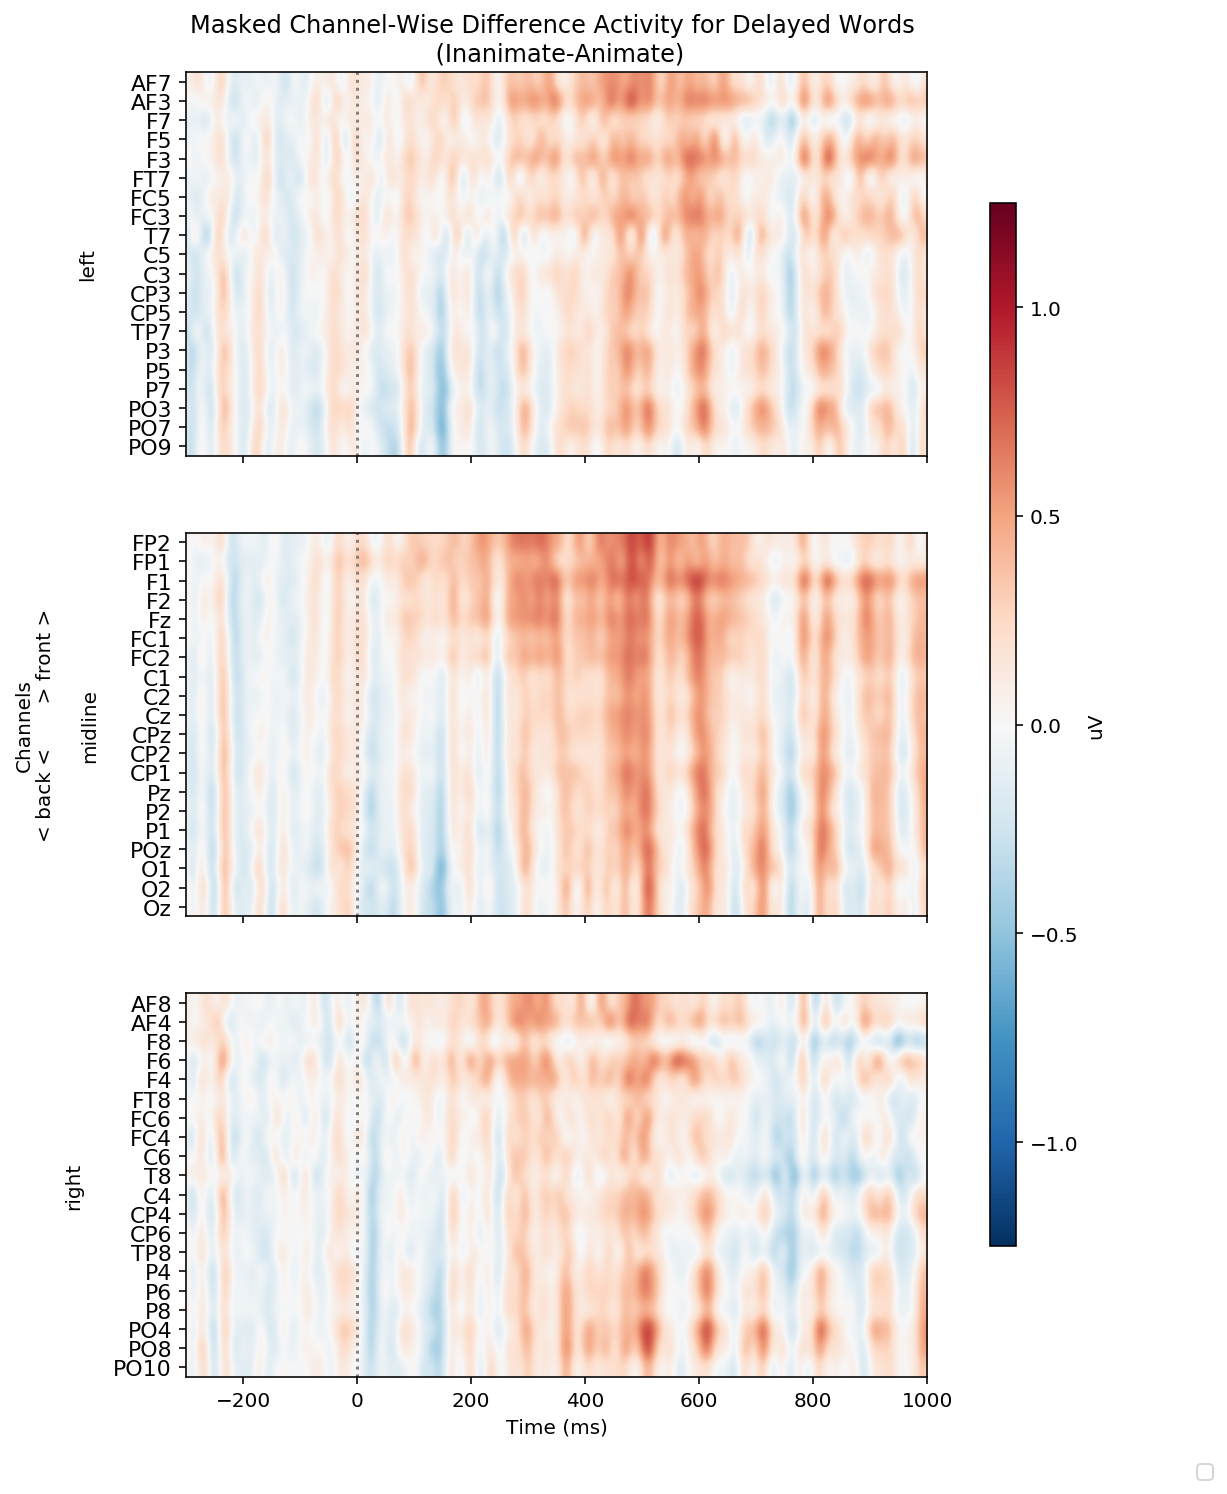

In [32]:
# plot channel-wise difference activity and mask for significance using contours (concrete-abstract)
plot_image_hemi(erps['anim']["diff_gr_avg"], p_vals=new_indsANIM.T, exp="anim");

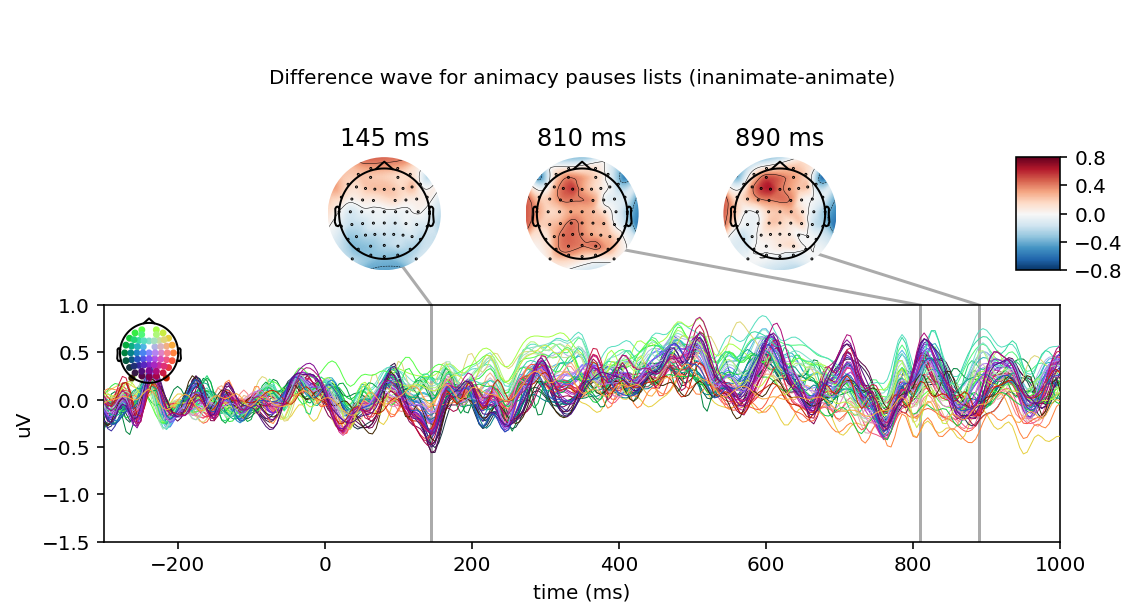

In [33]:
# plot difference plot (butterfly plot) indexing significant clusters in the topoplots (central) (concrete-abstract)
# no significant time points so topomaps index 3 local 'difference' points of maxima in Global Field Power
topomap_args = dict(mask=(new_indsANIM.T if str(type(inds))=="<class 'numpy.ndarray'>" else None),
     mask_params={"markersize":6},average=.05, vmin=-.8, vmax=.8) 

erps['anim']["diff_gr_avg"].plot_joint(topomap_args=topomap_args, ts_args={"ylim":{"eeg":[-1.5, 1.0]}},
                                       title="Difference wave for animacy pauses lists (inanimate-animate)");